# Autoencoders

In [1]:
import torch
import torch.nn as nn

import skorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import pandas as pd

/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/jhermosilla/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

In [3]:
train_set = datasets.CIFAR10(root='./data',
                             train=True,
                             download=True,
                             transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified


## Architecture

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

## 1. Hyperparameter Search

In [5]:
features = torch.stack([train_set[i][0].view(-1) for i in range(len(train_set))]).numpy()
targets = features

In [6]:
earlystopping = skorch.callbacks.EarlyStopping(monitor = 'train_loss', lower_is_better = False, patience = 10)
checkpoint = skorch.callbacks.Checkpoint(monitor = 'train_loss_best')

In [7]:
AutoencoderModel = NeuralNetRegressor(module=Autoencoder,
                                      module__input_dim=32 * 32 * 3, 
                                      module__latent_dim=128, 
                                      callbacks = [earlystopping, checkpoint],
                                      criterion=nn.MSELoss,
                                      train_split=None,
                                      max_epochs=15,                                        
                                      batch_size=64,
                                      device=dev,
                                      lr=0.01)

In [8]:
GridModel = {'lr': [0.0001, 0.001, 0.01],
             'batch_size': [32, 64]}

In [9]:
grid_search = GridSearchCV(AutoencoderModel,
                           param_grid=GridModel,
                           scoring='neg_mean_squared_error',
                           refit=True,                       
                           cv=2,                             
                           verbose=1)

In [10]:
grid_result = grid_search.fit(features, targets)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
  epoch    train_loss    cp     dur
-------  ------------  ----  ------
      1        0.0638     +  3.0749
      2        0.0638     +  2.8411
      3        0.0638     +  2.8573
      4        0.0638     +  3.0905
      5        0.0638     +  3.1417
      6        0.0638     +  3.1412
      7        0.0638     +  3.1555
      8        0.0638     +  3.1398
      9        0.0638     +  3.1466
     10        0.0638     +  2.3144
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss    cp     dur
-------  ------------  ----  ------
      1        0.0643     +  3.1457
      2        0.0643     +  3.1857
      3        0.0643     +  3.1570
      4        0.0643     +  3.1390
      5        0.0643     +  2.9823
      6        0.0643     +  2.8624
      7        0.0643     +  2.8319
      8        0.0643     +  2.8323
      9        0.0643     +  2.8419
     10        0.0643     +  2.8435
Stopping s

In [11]:
print("Best Parameters:", grid_result.best_params_)
print("Best Score:", -grid_result.best_score_)
grid_dict = grid_result.cv_results_

Best Parameters: {'batch_size': 32, 'lr': 0.01}
Best Score: 0.06400994956493378


In [15]:
pd.DataFrame({'param_lr': grid_dict['param_lr'],
              'param_batch_size': grid_dict['param_batch_size'],
              'mean_test_score': -grid_dict['mean_test_score'],
              'std_test_score': grid_dict['std_test_score']},
              index=pd.Index(grid_dict['rank_test_score'], name='rank_test_score'))

,param_lr,param_batch_size,mean_test_score,std_test_score
rank_test_score,,,,
6,0.0001,32,0.064032,0.000265
4,0.0010,32,0.064029,0.000269
1,0.0100,32,0.064010,0.000258
5,0.0001,64,0.064030,0.000272
3,0.0010,64,0.064028,0.000266
2,0.0100,64,0.064016,0.000271


## 2. Reconstruction

In [18]:
# Hyperparameters
input_dimension_ = 32*32*3
laten_dimension_ = 256
learning_rate_   = 0.0001
batch_size_     = 64
num_epochs_      = 20

In [19]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_, shuffle=True)

In [20]:
model = Autoencoder(input_dimension_, laten_dimension_)
model.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                                          lr=learning_rate_,
                                          betas=(0.9, 0.999),
                                          eps=1e-08,
                                          weight_decay=0,
                                          amsgrad=False)

In [22]:
for epoch in range(num_epochs_):
    model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images.view(images.size(0), -1))
        with torch.no_grad():
          train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/20], Loss: 0.0370
Epoch [2/20], Loss: 0.0239
Epoch [3/20], Loss: 0.0212
Epoch [4/20], Loss: 0.0190
Epoch [5/20], Loss: 0.0170
Epoch [6/20], Loss: 0.0162
Epoch [7/20], Loss: 0.0152
Epoch [8/20], Loss: 0.0144
Epoch [9/20], Loss: 0.0136
Epoch [10/20], Loss: 0.0131
Epoch [11/20], Loss: 0.0127
Epoch [12/20], Loss: 0.0124
Epoch [13/20], Loss: 0.0120
Epoch [14/20], Loss: 0.0117
Epoch [15/20], Loss: 0.0114
Epoch [16/20], Loss: 0.0111
Epoch [17/20], Loss: 0.0108
Epoch [18/20], Loss: 0.0106
Epoch [19/20], Loss: 0.0103
Epoch [20/20], Loss: 0.0100


In [23]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.to(dev)
        recon = model(data)
        break
recon1 = recon.view(64, 3, 32, 32)

<Figure size 1600x1200 with 0 Axes>

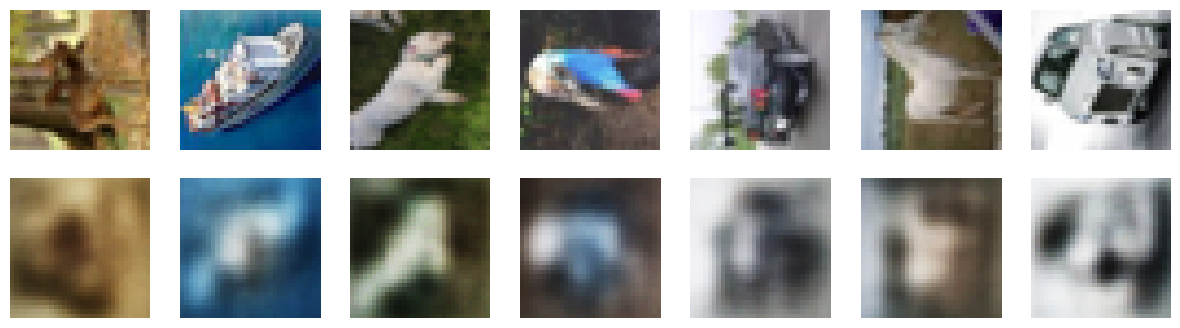

In [24]:
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().T)
    ax[1, i].imshow(recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()